# Binomial hierarchical model

We consider the problem of estimating a parameter $\theta$ using data from a small experiment and a prior distribution constructed from
similar previous (or historical) experiments. Mathematically, we will consider the current and historical experiments to be a random sample from a common population.

In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Alpha": r"$\alpha$", "Beta": r"$\beta$", "Theta": r"$\theta$"})

In the evaluation of drugs for possible clinical application, studies are routinely performed on rodents. For a particular study the immediate aim is to estimate $\theta$, the probability of tumor in a population of female laboratory rats that receive a zero dose of the drug (a control group). The data show that 4 out of 14 rats developed endometrial stromal polyps (a kind of tumor). It is natural to assume a binomial model for the number of tumors, given $\theta$. For convenience, we select a prior distribution for $\theta$ from the conjugate family, $\theta\sim\textsf{Beta}(\alpha,\beta)$.

In [3]:
RatTumor = pd.read_csv('Data/RatTumor.csv')
RatTumor['ObservedTheta'] = RatTumor['Y'] / RatTumor['N']

In [4]:
RatTumor.head()

,Y,N,ObservedTheta
0,0,20,0.0
1,0,20,0.0
2,0,20,0.0
3,0,20,0.0
4,0,20,0.0


The data is taken from *Tarone (1982). The use of historical control information in testing for a trend in proportions. Biometrics*. The table displays the values of the number of rats with tumors, $Y_j$, and the total number of rats $n_j$. The last row corresponds to the current experiment. If the conditions of the experiments where similar, then $\theta_j\overset{iid}{\sim}\theta$.

In [5]:
RatTumorPrevious = RatTumor[:-1]
RatTumorCurrent  = RatTumor[:-2:-1]

## Empirical Bayes

Using the historical data and the method of moments we can set some values for $\alpha$ and $\beta$. Since $\theta\sim\textsf{Beta}(\alpha,\beta)$, then $$\mathbb{E}(\theta)=\frac{\alpha}{\alpha+\beta}\text{ and }\mathbb{V}(\theta)=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}.$$ Let be $\bar{Y}_j=Y_j/n_j$, $\bar{\bar Y}$ the mean of $\bar Y_1,\ldots,\bar Y_J$, and $s_{\bar{Y}}^2$ their variance.

Then, we have to find the values of $\alpha$ and $\beta$ such that
$$\bar{\bar Y}=\frac{\alpha}{\alpha+\beta} \text{ and }s_{\bar{Y}}^2=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}.$$

Solving these equations, we find that $$\beta = \alpha\left(\frac{1-\bar{\bar Y}}{\bar{\bar Y}}\right)\text{ and }\alpha = \frac{\bar{\bar Y}^2(1-\bar{\bar Y})-\bar{\bar Y}s_{\bar{Y}}^2}{s_{\bar{Y}}^2}.$$

In [6]:
ThetaMean = RatTumorPrevious['ObservedTheta'].mean()
ThetaVar  = RatTumorPrevious['ObservedTheta'].var()

HatAlpha = (ThetaMean**2 * (1-ThetaMean) - ThetaMean * ThetaVar) / ThetaVar
HatBeta  = HatAlpha * (1-ThetaMean) / ThetaMean

In [7]:
HatAlpha.round(3), HatBeta.round(3)

(1.356, 8.615)

Using this simple estimate of the historical population distribution as a prior distribution for the current experiment yields a Beta($5.356,18.615$) posterior distribution for $\theta_{71}$.

In [8]:
with pm.Model() as ModelEmpiricalBayes:
    Theta = pm.Beta('Theta', alpha = HatAlpha, beta = HatBeta)
    Y = pm.Binomial('Y', n = RatTumorCurrent['N'], p = Theta, observed = RatTumorCurrent['Y'])

    TraceEmpiricalBayes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


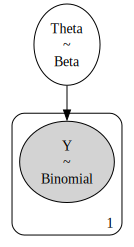

In [9]:
pm.model_to_graphviz(ModelEmpiricalBayes)

Posterior distribution for $\theta$, we add the current observed ratio of tumors in the sample

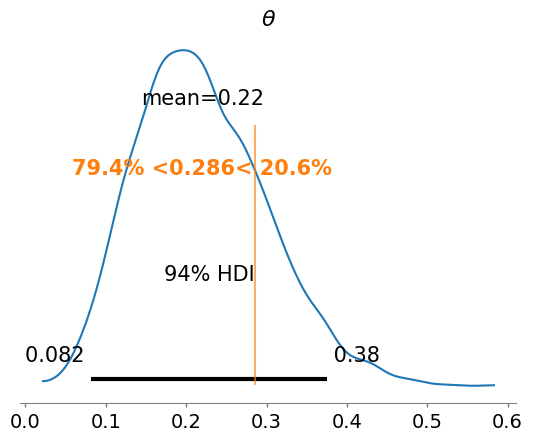

In [10]:
az.plot_posterior(
    TraceEmpiricalBayes
    , ref_val = round(RatTumorCurrent['ObservedTheta'], 3).to_list()[0]
    , labeller = labeller
)

Note that the prior information has resulted in a posterior distribution substantially lower than the crude proportion 4/14.

## Full Bayes

The prior for $\alpha$ and $\beta$ is 

$$p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

In order to use this prior, we have to define the logarithm of $p(\alpha, \beta)$ and use it in `pm.Potential`.

In [11]:
with pm.Model() as ModelFullBayes:
    # Our alpha and beta
    Alpha = pm.HalfFlat('Alpha')
    Beta  = pm.HalfFlat('Beta')
    pm.Potential('p(Alpha, Beta)', -(5/2)*np.log(Alpha + Beta))
    
    Theta = pm.Beta('Theta', alpha = Alpha, beta = Beta, shape = len(RatTumor))
    Y = pm.Binomial('Y', p = Theta, n = RatTumor['N'], observed = RatTumor['Y'])

    TraceFullBayes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


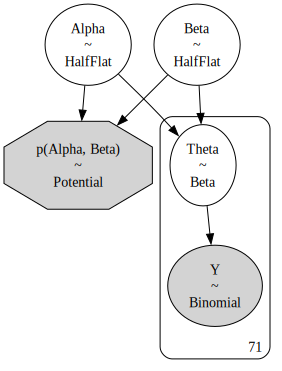

In [12]:
pm.model_to_graphviz(ModelFullBayes)

In [13]:
az.summary(TraceFullBayes, var_names = ['Alpha', 'Beta'], kind = 'stats')

,mean,sd,hdi_3%,hdi_97%
Alpha,2.391,0.883,1.107,4.074
Beta,14.237,5.315,5.939,23.816


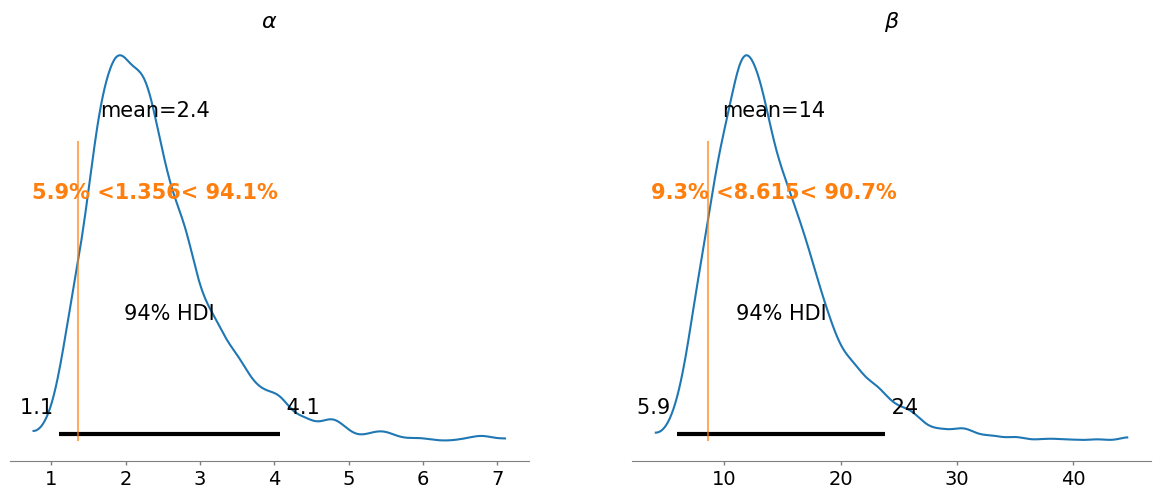

In [14]:
az.plot_posterior(
    TraceFullBayes
    , var_names = ['Alpha', 'Beta']
    , ref_val = [round(HatAlpha,3), round(HatBeta,3)]
    , labeller = labeller
)

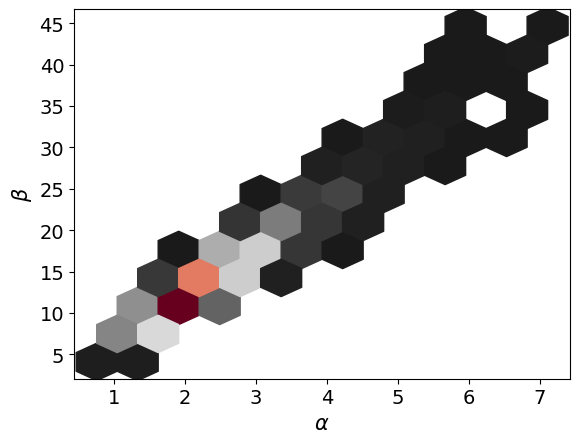

In [15]:
az.plot_pair(
    TraceFullBayes
    , var_names = ['Alpha', 'Beta']
    , kind = "hexbin"
    , hexbin_kwargs = {'cmap':'RdGy_r'}
    , labeller = labeller
)

Posterior medians and 95% highest posterior density of rat tumor rates, $\theta_j$ (plotted vs. observed tumor rates $y_j / n_j$). The rates $\theta_j$ are shrunk from their sample point estimetes, $Y_j/n_j$; experiments with fewer observations are shrunk more and have higher posterior variances.

In [16]:
SummaryTheta = az.summary(
    TraceFullBayes
    , var_names = ['Theta']
    , stat_focus = 'median'
    , kind = 'stats'
    , hdi_prob=0.95
)

SummaryTheta = SummaryTheta.reset_index(drop=True)

RatTumor = pd.concat([RatTumor, SummaryTheta], axis=1)

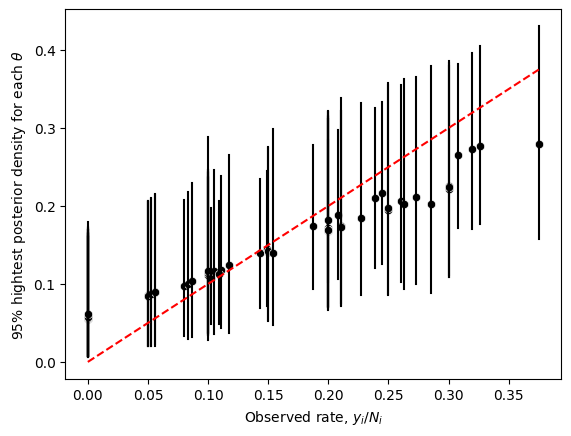

In [17]:
sns.scatterplot(data=RatTumor, x='ObservedTheta', y='median', color='k')

for i in range(len(RatTumor)):
    plt.plot(
        [RatTumor.loc[i, 'ObservedTheta'], RatTumor.loc[i, 'ObservedTheta']]
        , [RatTumor.loc[i, 'eti_2.5%'], RatTumor.loc[i, 'eti_97.5%']]
        , color='k'
    )
    
plt.plot(
    [RatTumor['ObservedTheta'].min(), RatTumor['ObservedTheta'].max()]
    , [RatTumor['ObservedTheta'].min(), RatTumor['ObservedTheta'].max()]
    , color='r'
    , linestyle='--'
)

plt.xlabel(r'Observed rate, $y_i/N_i$')
plt.ylabel(r'95% hightest posterior density for each $\theta$')